In [1]:
from seirsplus.models import *
import networkx
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from hyperopt import hp
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import math
from utils.metrics_util import evaluate
from utils.hyperparam_util import hyperparam_tuning
from utils.plot_util import generate_summary_data, plot

## Common Function Definitions

In [80]:
#### Since the model outputs a different format than the CSSEGISandData, we need to align them
#### which means - finding the appropriate prediction for the model for a particular date

### modelI - Time Series Prediction output by model (model.numI)
### modelT - Time Series of the model (model.tseries)
### dates  - dates in the true file that we have from CSSEGISandData - datetime object


def alignTimeSeries(modelI, modelT, dates):
    finalModelPredictions = []
    count = 0
    day0 = dates[0]
    for date in dates:
        t = (date-day0).days
        #print(t)
        while(modelT[count]<=t):
            count+=1
            if(count == len(modelT)):
                print("Last prediction reached - Number of predictions less than required")
                finalModelPredictions.append(modelI[count-1])
                finalModelPredictions_df = pd.DataFrame()
                finalModelPredictions_df['date'] = [date.strftime("%-m/%-d/%y") for date in dates]
                finalModelPredictions_df['predicted_count'] = finalModelPredictions
                return finalModelPredictions_df
        
        x0 = modelI[count] - (((modelI[count] - modelI[count-1])/(modelT[count] - modelT[count-1]))*(modelT[count] -  t))
        finalModelPredictions.append(x0)
    finalModelPredictions_df = pd.DataFrame()
    finalModelPredictions_df['date'] = [date.strftime("%-m/%-d/%y") for date in dates]
    finalModelPredictions_df['predicted_count'] = finalModelPredictions
      
    return finalModelPredictions_df

def get_merged_df(orig, pred):
    merge = orig.merge(pred, right_on="date", left_on='date')
    merge = merge.dropna()
    return merge        

### expected output is a dataframe containing date, actual_count, predicted_count
def predict(region_row, infected_col_name, fixedParams, search_space, n_days, day0, model_type='deterministic'):
    if(model_type=='deterministic'):        
#         init_beta = search_space['transmission_rate'][0]
        recovered_count=region_row["current_recovered_count"]
        r0 = search_space['r0']
        init_sigma = 1./fixedParams['incubation_period'][0]
        init_beta = r0*init_sigma
        init_gamma = 1./search_space['infectious_period']
        initN = region_row['population']
        initI = region_row[infected_col_name]
        initE = region_row[infected_col_name] * search_space['EbyIRation'] ### CHECK EXPOSURE - 50-100
        initR = recovered_count
        model = SEIRSModel(beta=init_beta, sigma=init_sigma, gamma=init_gamma, initN=initN, initI=initI, initE = initE, initR = initR)
        
        
        
        if(len(fixedParams['time_stamps'])>1):
            checkpoints = {
                't' : params['time_stamps'],
                'sigma' : reciprocal_list(params['incubation_period']), 
                'gamma' : reciprocal_list(params['infectious_period']),
                'beta' : params['transmission_rate']
            }
            
            model.run(T=n_days, checkpoints=checkpoints,verbose=False)            
        else:
            model.run(T=n_days,verbose=False)
            
    print(infected_col_name)        
    
    dates_dt = []
    for i in range(n_days):
        date = (day0 + timedelta(days=i))
        #print(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        dates_dt.append(date)
        
    predicted_ts = alignTimeSeries(model.numI, model.tseries, dates_dt)    
    region_row = convert_dataframe(region_row, day0, n_days)
    merge_df = get_merged_df(region_row, predicted_ts)

    return merge_df



In [81]:
def convert_dataframe(region_timeseries_df, day0, n_days):
        dates_str=[]
        for i in range(n_days):
            date = (day0 + timedelta(days=i))
            dates_str.append(date.strftime(format="%-m/%-d/%y").strip())    
        df = pd.DataFrame(region_timeseries_df[dates_str])
        df.columns = ['actual_count']
        df = df.reset_index()
        df = df.rename(columns ={ 'index': 'date'})
        return df

In [91]:
##day0 needs to be datetime
def run(search_space, time_series_file, day0, 
         n_days, fixedParams, opt = 'rmse'):
    print(search_space)
    region_timeseries_df = pd.read_csv(time_series_file)
    if region_timeseries_df.shape[0] > 1:
        raise Exception("Error in data, expecting only 1 row")
    row = region_timeseries_df.iloc[0]
    predicted_df = predict(row, day0.strftime("%-m/%-d/%y"), fixedParams, search_space, n_days, day0, model_type)        
    metrics = evaluate(predicted_df["actual_count"], predicted_df["predicted_count"])
    return metrics[opt], predicted_df

## Top level function

In [92]:
##day0 needs to be datetime, have added this wrapper function since hyperopt requires return value to be single number
def run_for_optimize(search_space, time_series_file, day0, 
         n_days, fixedParams, opt = 'rmse'):
    error, predict_df= run(search_space, time_series_file, day0, 
         n_days, fixedParams, opt)
    return error

In [93]:
def run_and_plot(input_file, input_file_test, day0, n_days_val, n_days_test, region_col, fixedParams, search_space,max_evals, isPlot ,opt):
    day0= datetime.strptime(day0,"%m/%d/%y")
    tuneParameters = partial(run_for_optimize, time_series_file = input_file, 
                   day0=day0, n_days = n_days_val, fixedParams = fixedParams, opt = opt)

    best_params, trials,valError = hyperparam_tuning(tuneParameters, search_space, max_evals)
    print(best_params)
    if( not n_days_test == -1):
        day0new = day0 + timedelta(days=n_days_val-1)
        print("Running for test")
        testError, test_prediction_df = run(best_params, input_file_test, day0new, n_days_test, fixedParams, opt = opt)
        if(isPlot):
            error, prediction_df = run(best_params, input_file, day0, (n_days_val+n_days_test) , fixedParams, opt = opt)
            plot(generate_summary_data(prediction_df,  F_hospitalized,F_need_ICU,F_need_Ventilator,F_fatality), best_params["r0"])    
        print("Validation Error:" + str(valError))
        print("Test Error:" + str(testError))
        return trials

    else:
        if(isPlot):
            error, prediction_df= run(best_params, input_file, day0, (n_days_val) , fixedParams, opt = opt)
            plot(generate_summary_data(prediction_df,  F_hospitalized,F_need_ICU,F_need_Ventilator,F_fatality), best_params["r0"])        
        print("Validation Error:" + str(valError))
        return trials
        

In [94]:
def prepare_data(region_col, region_name, population, day0, n_days_val, outputFileName, outputFileNameTest, global_file_name, globalRecovered_file_name):
    region_timeseries_df = pd.read_csv(global_file_name)
    region_timeseries_df = region_timeseries_df.groupby([region_col]).agg('sum')
    region_timeseries_df= region_timeseries_df.reset_index()
    recovered = pd.read_csv(globalRecovered_file_name)
    recovered = recovered.reset_index()
    recovered = recovered[[region_col, day0]]
    recovered = recovered.rename(columns = {day0: 'current_recovered_count'})
    recovered = recovered.groupby([region_col]).agg('sum')
    merged = region_timeseries_df.merge(recovered, on = region_col, how="outer")
    merged = merged.fillna(0)
    merged = merged[merged[region_col] == region_name]
    merged['population'] = population
    merged.to_csv(outputFileName)
    
    recovered = pd.read_csv(globalRecovered_file_name)
    recovered = recovered.reset_index()
    day0Obj = datetime.strptime(day0, "%m/%d/%y")
    daynew = datetime.strftime(day0Obj, "%-m/%-d/%y")
    recovered = recovered[[region_col, daynew]]
    recovered = recovered.rename(columns = {daynew: 'current_recovered_count'})
    recovered = recovered.groupby([region_col]).agg('sum')
    merged = region_timeseries_df.merge(recovered, on = region_col, how="outer")
    merged = merged.fillna(0)
    merged = merged[merged[region_col] == region_name]
    merged['population'] = population
    merged.to_csv(outputFileNameTest)
    
    
    return merged

In [100]:
n_days_val = 10
n_days_test = 10


F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026

search_space = {
     'r0' : hp.choice('r0',[5.9094]),
     'EbyIRation': hp.choice('EbyIRation', [1.0024]),
     'infectious_period': hp.choice('infectious_period', [5.617])
 }

# search_space = {
#      'r0' : hp.uniform('r0', 0.8, 6),
#      'EbyIRation': hp.uniform('EbyIRation', 1, 70),
#      'infectious_period': hp.uniform('infectious_period', 1, 10)
#  }


fixedParams = {'time_stamps' : [1],
               'incubation_period' : [6]  # 4-7 5.2, 4
              }

model_type = 'deterministic'
day0 = '3/25/20' # "%-m/%-d/%y"
global_file_name = '../data/time_series_covid19_confirmed_India_district_20200416.csv'
globalRecovered_file_name = '../data/time_series_covid19_Recovered_India_district_20200416.csv'

# region_col = 'Country/Region'
region_col = 'Province/State'

region_name = 'Mumbai'
population = 25000000
input_file = './time_series_{}.csv'.format(region_name)
input_file_test = './time_series_test_{}.csv'.format(region_name)

prepare_data(region_col = region_col, region_name=region_name, population= population, day0=day0,n_days_val=n_days_val,
             outputFileName = input_file, outputFileNameTest = input_file_test,global_file_name=global_file_name, globalRecovered_file_name= globalRecovered_file_name)
 
error = 'mape'
max_evals = 1

{'EbyIRation': 1.0024, 'infectious_period': 5.617, 'r0': 5.9094}
t = 9.90                                             
3/25/20                                              
100%|██████████| 1/1 [00:00<00:00, 11.67trial/s, best loss: 7.18745597914]
('Best fit:', {'EbyIRation': 1.0024, 'infectious_period': 5.617, 'r0': 5.9094})
('Best Loss:', 7.187455979140671)
{'EbyIRation': 1.0024, 'infectious_period': 5.617, 'r0': 5.9094}
{'EbyIRation': 1.0024, 'infectious_period': 5.617, 'r0': 5.9094}
t = 9.90
3/25/20
      date actual_count  predicted_count  hospitalizations_count  ICU_count  \
0  3/25/20           96        96.000000                    25.0        8.0   
1  3/26/20           98       100.893072                    26.0        8.0   
2  3/27/20          102       115.933530                    30.0       10.0   
3  3/28/20          146       139.998667                    36.0       11.0   
4  3/29/20          156       173.080475                    45.0       14.0   
5  3/30/20       

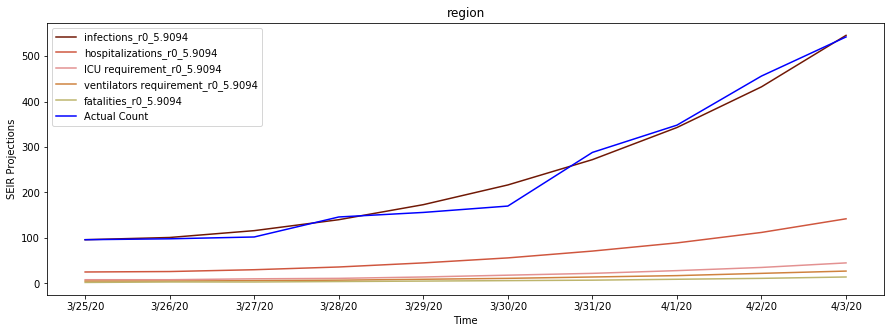

In [101]:
sorted_dict = run_and_plot(input_file, input_file_test, day0,  n_days_val, n_days_test, region, fixedParams, search_space=search_space,max_evals=max_evals, isPlot=True ,opt=error)
